<a href="https://colab.research.google.com/github/KeysiYTS/parkisons-detection/blob/main/Parkisons_Deasease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Dataset from UCI](https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/)

# LIBS

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [80]:
# models
import xgboost as xgb
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

# tools
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

# metrics and viz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, plot_roc_curve

# scaler and transformers
from sklearn.preprocessing import StandardScaler



# INITIALIZING

In [3]:
file_path = '/content/drive/MyDrive/0_Machine_Learning/Projetos/Parkison`s DeseaseDetection/parkinsons.data'

In [4]:
df = pd.read_csv(file_path)
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

There are no `null` cells, and 23 of the 24 columns are `numerical`.  
Also, the types of variables are very different. It varies from a measure of frequency to percentage. It will demand a scaler/normalizer 

In [6]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,0.015664,0.017878,0.024081,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,0.010153,0.012024,0.016947,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,0.004550,0.005700,0.007190,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,0.008245,0.009580,0.013080,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,0.012790,0.013470,0.018260,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,0.020265,0.022380,0.029400,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,0.056470,0.079400,0.137780,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


# EXPLORING THE DATASET

In [7]:
df.columns.values

array(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)',
       'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ',
       'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3',
       'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status',
       'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE'], dtype=object)

## Checking `name`column

In [8]:
df.name

0      phon_R01_S01_1
1      phon_R01_S01_2
2      phon_R01_S01_3
3      phon_R01_S01_4
4      phon_R01_S01_5
            ...      
190    phon_R01_S50_2
191    phon_R01_S50_3
192    phon_R01_S50_4
193    phon_R01_S50_5
194    phon_R01_S50_6
Name: name, Length: 195, dtype: object

## Checking `status` column

In [9]:
df.status

0      1
1      1
2      1
3      1
4      1
      ..
190    0
191    0
192    0
193    0
194    0
Name: status, Length: 195, dtype: int64

In [10]:
df.status.unique()

array([1, 0])

In [11]:
df.status.value_counts()

1    147
0     48
Name: status, dtype: int64

### Checking the status distribution

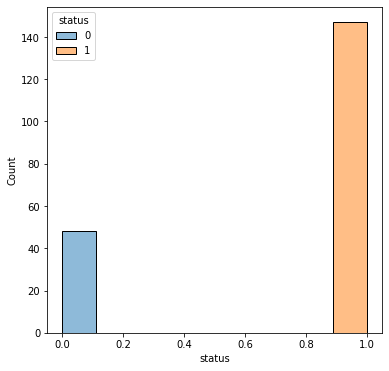

In [12]:
plt.figure(figsize=(6,6))
sns.histplot(data=df,
             x=df.status, hue=df.status)
plt.show()

the output are unbalanced. I might use SMOTE

# CORRELATIONS

In [13]:
correlations = df.corr()

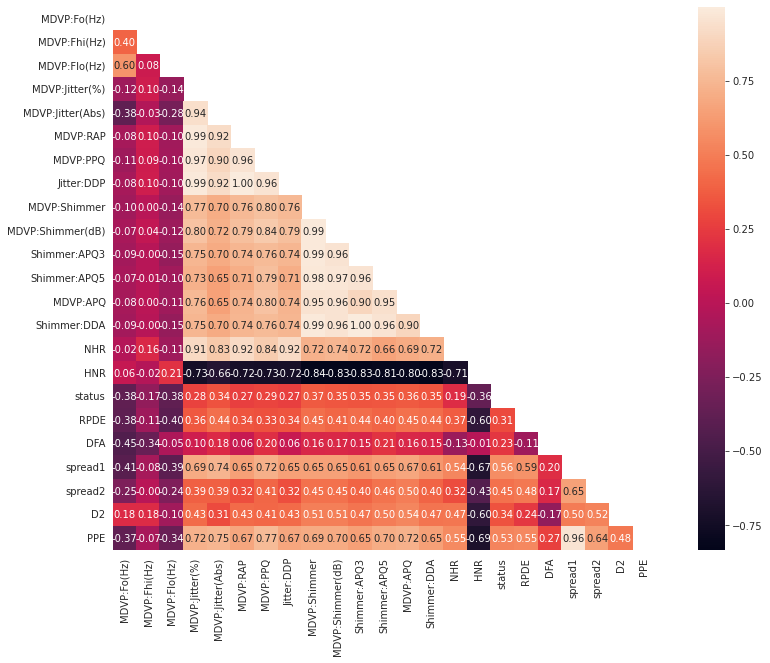

In [14]:
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(correlations, mask=mask, 
                     annot=True,fmt='.2f', square=True)
plt.show()

In [15]:
correlations[correlations >.8].sum()

MDVP:Fo(Hz)         1.000000
MDVP:Fhi(Hz)        1.000000
MDVP:Flo(Hz)        1.000000
MDVP:Jitter(%)      6.601770
MDVP:Jitter(Abs)    5.514288
MDVP:RAP            5.790024
MDVP:PPQ            7.274652
Jitter:DDP          5.790056
MDVP:Shimmer        5.895427
MDVP:Shimmer(dB)    7.491913
Shimmer:APQ3        5.807537
Shimmer:APQ5        5.825873
MDVP:APQ            6.457636
Shimmer:DDA         5.807546
NHR                 5.425603
HNR                 1.000000
status              1.000000
RPDE                1.000000
DFA                 1.000000
spread1             1.962435
spread2             1.000000
D2                  1.000000
PPE                 1.962435
dtype: float64

- spread1 && PPE  
- Shimmer:DDA && Shimmer:APQ3
- Jitter:DDP && MDVP:RAP                      

# INFORMATION ABOUT THE FEATURES

Looking for the meaning of MDVP I`ve found this relation table:   [NCBI](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5434464/)  

- MDVP:F0 (Hz)=	Average vocal fundamental frequency  
- MDVP:Fhi (Hz)=	Maximum vocal fundamental frequency  
- MDVP:Flo (Hz)=	Minimum vocal fundamental frequency  
- MDVP:Jitter(%)= MDVP jitter in percentage  
- MDVP:Jitter(Abs)=	MDVP absolute jitter in ms  
- MDVP:RAP =	MDVP relative amplitude perturbation  
- MDVP:PPQ=	MDVP five-point period perturbation quotient  
- Jitter:DDP=	Average absolute difference of differences between jitter cycles  
- MDVP:Shimmer=	MDVP local shimmer  
- MDVP:Shimmer(dB)=	MDVP local shimmer in dB  
- Shimmer:APQ3=	Three-point amplitude perturbation quotient  
- Shimmer:APQ5=	Five-point amplitude perturbation quotient  
- MDVP:APQ11=	MDVP 11-point amplitude perturbation quotient  
- Shimmer:DDA=	Average absolute differences between the amplitudes of consecutive periods  
- NHR=	Noise-to-harmonics ratio  
- HNR=	Harmonics-to-noise ratio  
- RPDE=	Recurrence period density entropy measure  
-D2=	Correlation dimension  
-DFA=	Signal fractal scaling exponent of detrended fluctuation analysis  
- Spread1	Two nonlinear measures of fundamental  
- Spread2	= Frequency variation
- PPE =	Pitch period entropy

# DUMMY CLASSIFIER

In [16]:
x_dummy = df.drop(columns=['name', 'status'])
y_dummy = df.status

In [17]:
x_train_dummy, x_test_dummy, y_train_dummy, y_test_dummy = train_test_split(x_dummy, y_dummy,
                                                                            test_size=.3,
                                                                            random_state=64)

In [18]:
dummy_cl = DummyClassifier(strategy='stratified',random_state=64)

In [19]:
dummy_cl.fit(x_train_dummy, y_train_dummy)

DummyClassifier(constant=None, random_state=64, strategy='stratified')

In [20]:
dummy_predictions = dummy_cl.predict(x_test_dummy)

In [21]:
dummy_score = dummy_cl.score(x_test_dummy, y_test_dummy)

## Dummy Score

In [22]:
dummy_score

0.711864406779661

## Dummy Confusion Matrix

In [23]:
dummy_confusion_matrix = confusion_matrix(y_test_dummy, dummy_predictions)

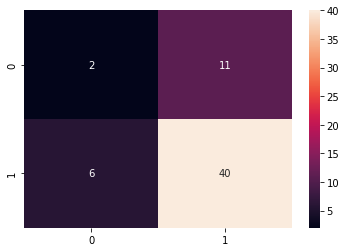

In [24]:
sns.heatmap(dummy_confusion_matrix, annot=True)

## Dummy Roc Curve

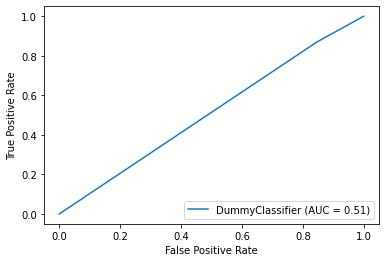

In [25]:
plot_roc_curve(dummy_cl,x_test_dummy,y_test_dummy)

Although the accuracy of the model is high, it's ROC is not good enough

# TRAIN & TEST

In [26]:
x = df.drop(columns=['name', 'status'])
y = df.status

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.3,
                                                    random_state=64)

# GENERAL FUNCTIONS

## Confusion Matrix

In [28]:
def conf_matrix(y_test, y_pred):
 conf_matrix = confusion_matrix(y_test,y_pred)
 conf_matrix_plot = sns.heatmap(conf_matrix, annot=True)
 return conf_matrix_plot

## ROC Curve

In [29]:
def roc_curve(model, x_test, y_test):
  return plot_roc_curve(model, x_test, y_test)

## Model Score 

In [30]:
def show_score(model, model_name, x_test, y_test):
  model_score = model.score(x_test, y_test)
  return print(f'The accuracy for the {model_name} is: %.2f%%' % (model_score*100))

# DECISION TREE

In [31]:
def dtree(x_train, y_train):
  dtree = DecisionTreeClassifier(max_depth=3,
                               random_state=64)
  dtree.fit(x_train, y_train)
  return dtree

In [32]:
dtree = dtree(x_train, y_train)

In [33]:
def dtree_pred(x_test):
 dtree_predictions = dtree.predict(x_test)
 return dtree_predictions

In [34]:
dtree_predictions = dtree_pred(x_test)

## Dtree Score

In [35]:
show_score(dtree, 'Decision Tree Classifier', x_test, y_test)

The accuracy for the Decision Tree Classifier is: 84.75%


## Dtree confusion matrix

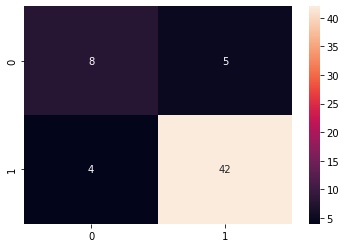

In [36]:
conf_matrix(y_test,dtree_predictions)

## Dtree Roc Curve

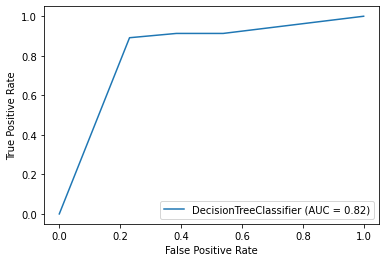

In [37]:
roc_curve(dtree, x_test, y_test)

# XGBOOST CLASSIFIER

In [38]:
xgb_classifier = xgb.XGBClassifier(max_depth=3, 
                                   random_state=64)

In [39]:
xgb_classifier.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=64,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## XGB Classifier score

In [40]:
xgb_classif_prediction = xgb_classifier.predict(x_test)

In [41]:
xgb_classif_proba = xgb_classifier.predict_proba(x_test)

In [42]:
show_score(xgb_classifier, 'XGB Classifier', x_test, y_test)

The accuracy for the XGB Classifier is: 88.14%


## XGB Classifier Confusion Matrix

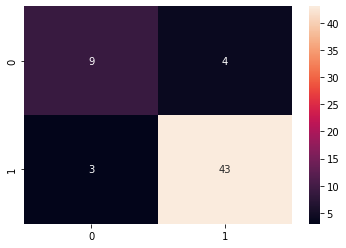

In [43]:
conf_matrix(y_test, xgb_classif_prediction)

## XGB Classifier Roc Curve

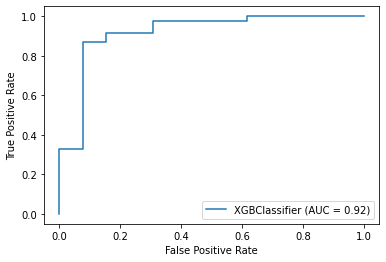

In [44]:
roc_curve(xgb_classifier, x_test, y_test)

# LOGISTIC REGRESSION

In [45]:
log_regression = LogisticRegressionCV(max_iter=1000,
                                      random_state=64)

In [46]:
log_regression.fit(x_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=64, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [47]:
log_regression_pred = log_regression.predict(x_test)

## Logistic Regression Score

In [48]:
show_score(log_regression, 'Logistic Regression', x_test, y_test)

The accuracy for the Logistic Regression is: 79.66%


## Logistic Regression Confusion Matrix

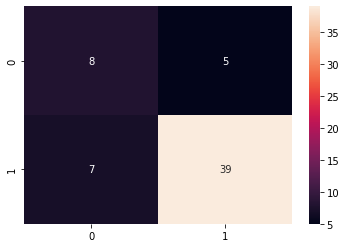

In [49]:
conf_matrix(y_test, log_regression_pred)

## Logistic Regression Roc Curve

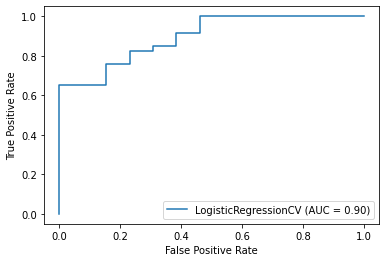

In [50]:
plot_roc_curve(log_regression, x_test, y_test)

# STANDARD SCALING

In [51]:
std_scaler = StandardScaler()

In [52]:
x_train_std = std_scaler.fit_transform(x_train)
x_test_std = std_scaler.transform(x_test)

# DECISION TREE W/ STD SCALER

In [53]:
dtree.fit(x_train_std, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=64, splitter='best')

## Decision Tree w/ std scaler score

In [54]:
dtree_prediction = dtree.predict(x_test_std)

In [55]:
show_score(dtree, 'Decision Tree W/ Std Scaler', x_test_std, y_test)

The accuracy for the Decision Tree W/ Std Scaler is: 84.75%



## Decision Tree w/ std scaler Confusion Matrix

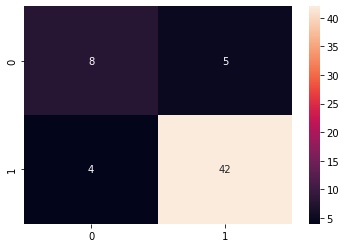

In [56]:
conf_matrix(y_test, dtree_prediction)

## Decision Tree w/ std scaler ROC Curve

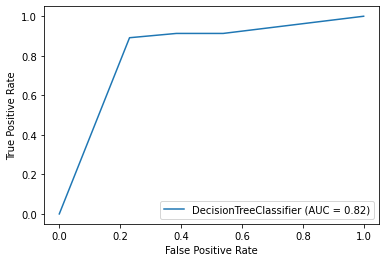

In [57]:
plot_roc_curve(dtree, x_test_std, y_test)

# XGBOOST CLASSIFIER W/ STD SCALER

In [65]:
xgb_classifier.fit(x_train_std, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=64,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Xgboost/ std scaler score

In [66]:
show_score(xgb_classifier, 'XgBoost', x_test_std,y_test)

The accuracy for the XgBoost is: 88.14%


To scale the dataset had no effect in the result

# SECOND RUN

# SMOTE

**Synthetic Minority Oversampling Technique**  
SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [58]:
smote = SMOTE()

In [59]:
x_smote, y_smote = smote.fit_resample(x, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [60]:
x_smote

array([[1.19992000e+02, 1.57302000e+02, 7.49970000e+01, ...,
        2.66482000e-01, 2.30144200e+00, 2.84654000e-01],
       [1.22400000e+02, 1.48650000e+02, 1.13819000e+02, ...,
        3.35590000e-01, 2.48685500e+00, 3.68674000e-01],
       [1.16682000e+02, 1.31111000e+02, 1.11555000e+02, ...,
        3.11173000e-01, 2.34225900e+00, 3.32634000e-01],
       ...,
       [2.44192846e+02, 2.54980801e+02, 2.32221332e+02, ...,
        1.04724405e-01, 2.35306783e+00, 9.36052287e-02],
       [1.13452557e+02, 1.31545273e+02, 1.05897118e+02, ...,
        2.13599711e-01, 2.16124932e+00, 1.71087860e-01],
       [2.07935880e+02, 2.48336289e+02, 8.96607326e+01, ...,
        1.33962020e-01, 2.79729181e+00, 1.73389752e-01]])

In [61]:
y_smote

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

## Train and Test with SMOTE

In [67]:
x_train_smote, x_test_smote, y_train_smote,y_test_smote = train_test_split(x_smote, y_smote,
                                                                           test_size=.3,
                                                                           random_state=64)

# DECISION TREE W/ SMOTE

In [68]:
dtree.fit(x_train_smote, y_train_smote)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=64, splitter='best')

## Decision Tree score w/ SMOTE

In [69]:
dtree_pred = dtree.predict(x_test_smote)

In [70]:
show_score(dtree, 'Decision Tree W/ SMOTE', x_test_smote, y_test_smote)

The accuracy for the Decision Tree W/ SMOTE is: 87.64%


## Decision Tree w/ SMOTE Confusion Matrix

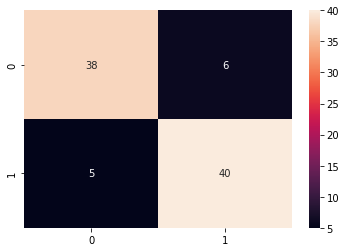

In [72]:
conf_matrix(y_test_smote, dtree_pred)

## Decision Tree w/ SMOTE ROC Curve

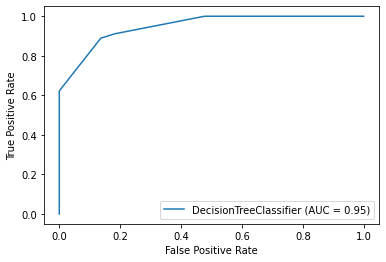

In [74]:
plot_roc_curve(dtree, x_test_smote, y_test_smote)

# XGBOOST CLASSIFIER W/ SMOTE

In [75]:
xgb_classifier.fit(x_train_smote, y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=64,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [77]:
xgb_pred = xgb_classifier.predict(x_test_smote)

## XGBoost score w/ SMOTE 

In [76]:
show_score(xgb_classifier, 'XGBoost W/ SMOTE', x_test_smote, y_test_smote)

The accuracy for the XGBoost W/ SMOTE is: 94.38%


## XGBoost w/ SMOTE Confusion Matrix 

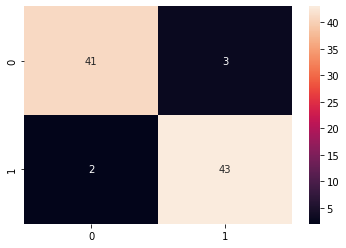

In [78]:
conf_matrix(y_test_smote, xgb_pred)

## XGBoost w/ SMOTE ROC Curve

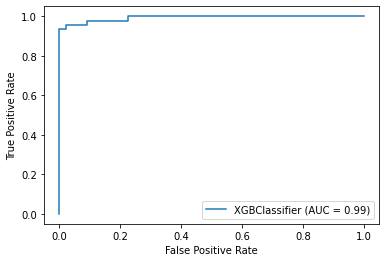

In [79]:
plot_roc_curve(xgb_classifier, x_test_smote, y_test_smote)

# THIRD RUN

# USING RFE

Feature ranking with **R**ecursive **F**eature **E**limination.  

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [150]:
selector = RFE(xgb_classifier, 
               n_features_to_select=11)

In [151]:
selector.fit(x_smote, y_smote)

RFE(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                            colsample_bylevel=1, colsample_bynode=1,
                            colsample_bytree=1, gamma=0, learning_rate=0.1,
                            max_delta_step=0, max_depth=3, min_child_weight=1,
                            missing=None, n_estimators=100, n_jobs=1,
                            nthread=None, objective='binary:logistic',
                            random_state=64, reg_alpha=0, reg_lambda=1,
                            scale_pos_weight=1, seed=None, silent=None,
                            subsample=1, verbosity=1),
    n_features_to_select=11, step=1, verbose=0)

In [152]:
selector.ranking_

array([ 1,  1,  2,  6,  1,  1,  8, 11,  1,  3,  5,  7,  1, 12, 10,  9,  1,
        4,  1,  1,  1,  1])

In [153]:
mapper = {'variables': x.columns, 
          'ranking': selector.ranking_}

In [154]:
important_variables = pd.DataFrame(mapper)
important_variables.head()

,variables,ranking
0,MDVP:Fo(Hz),1
1,MDVP:Fhi(Hz),1
2,MDVP:Flo(Hz),2
3,MDVP:Jitter(%),6
4,MDVP:Jitter(Abs),1


In [155]:
top_five_features = important_variables.query('ranking == 1')
top_five_features

,variables,ranking
0,MDVP:Fo(Hz),1
1,MDVP:Fhi(Hz),1
4,MDVP:Jitter(Abs),1
5,MDVP:RAP,1
8,MDVP:Shimmer,1
12,MDVP:APQ,1
16,RPDE,1
18,spread1,1
19,spread2,1
20,D2,1


## Getting the five most relevant features

In [156]:
x_smote_df = pd.DataFrame(x_smote, columns=x.columns)
x_smote_df.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [157]:
x_rfe = x_smote_df[top_five_features.variables.values]
x_rfe

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Jitter(Abs),MDVP:RAP,MDVP:Shimmer,MDVP:APQ,RPDE,spread1,spread2,D2,PPE
0,119.992000,157.302000,0.000070,0.003700,0.043740,0.029710,0.414783,-4.813031,0.266482,2.301442,0.284654
1,122.400000,148.650000,0.000080,0.004650,0.061340,0.043680,0.458359,-4.075192,0.335590,2.486855,0.368674
2,116.682000,131.111000,0.000090,0.005440,0.052330,0.035900,0.429895,-4.443179,0.311173,2.342259,0.332634
3,116.676000,137.871000,0.000090,0.005020,0.054920,0.037720,0.434969,-4.117501,0.334147,2.405554,0.368975
4,116.014000,141.781000,0.000110,0.006550,0.064250,0.044650,0.417356,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...
289,200.645209,210.487905,0.000010,0.001149,0.009865,0.007419,0.402628,-7.688720,0.175755,1.842571,0.062735
290,115.912777,121.578655,0.000035,0.001663,0.015520,0.015279,0.579740,-6.157156,0.170922,1.971386,0.169395
291,244.192846,254.980801,0.000009,0.001156,0.014878,0.010752,0.448922,-7.093616,0.104724,2.353068,0.093605
292,113.452557,131.545273,0.000032,0.001699,0.014646,0.012966,0.450110,-6.187192,0.213600,2.161249,0.171088


# TRAIN AND TEST

In [158]:
x_train_rfe, x_test_rfe, y_train_rfe, y_test_rfe = train_test_split(x_rfe, y_smote,
                                                                    test_size=.3,
                                                                    random_state=64)

# XGBOOST CLASSIFIER W/ SMOTE & RFE

In [159]:
xgb_classifier.fit(x_train_rfe, y_train_rfe)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=64,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [160]:
xgb_rfe_pred = xgb_classifier.predict(x_test_rfe)

## XGBoost score w/ SMOTE & RFE

In [161]:
show_score(xgb_classifier,'XGBoost w/ SMOTE & RFE', x_test_rfe, y_test_rfe)

The accuracy for the XGBoost w/ SMOTE & RFE is: 93.26%


## XGBoost w/ SMOTE & RFE Confusion Matrix 

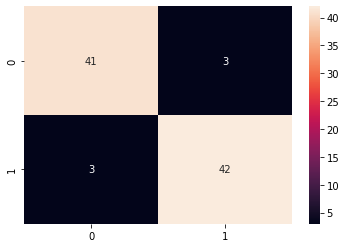

In [162]:
conf_matrix(y_test_rfe, xgb_rfe_pred)

## XGBoost w/ SMOTE & RFE ROC Curve

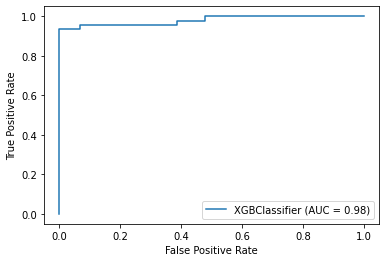

In [163]:
plot_roc_curve(xgb_classifier, x_test_rfe,y_test_rfe)